In [1]:
def full(shape, val):
    return [[val for _ in range(shape[1])] for _ in range(shape[0])]

def manhattan(p1, p2):
    return abs(p1[0]-p2[0])+abs(p1[1]-p2[1])

In [2]:
from heapq import heappush, heappop
import math
import numpy as np

inf = float('inf')

moves=[(0, 1), (1, 0), (0, -1), (-1, 0)]

r = moves[0]
d = moves[1]
l = moves[2]
u = moves[3]

two_moves_to_rotation ={

    #0 - forward
    #1 - right
    #2 - left

    #equals 
    (r,r):0,
    (d,d):0,
    (l,l):0,
    (u,u):0,
    #right
    (r,d):1,
    (r,u):2,
    #down
    (d,r):2,
    (d,l):1,
    #left
    (l,d):2,
    (l,u):1,
    #up
    (u,r):1,
    (u,l):2,
    #opposite
    (u,d):3,
    (d,u):3,
    (l,r):3,
    (r,l):3,
}

def reconstruct_dict_path(start, goal, came_from):
    current = came_from[goal]
    if current == start:
        return []
    return [current] + reconstruct_dict_path(start, current, came_from)

def euklid_dist_2d(p1, p2):
    return math.sqrt(pow(p1[0]-p2[0],2)+pow(p1[1]-p2[1],2))

def a_star(start, goal, env, heuristic=manhattan):
    '''
    start: (x,y) tuple, 2d startpoint
    goal:  (x,y) tuple, 2d goalpoint
    env:   2d numpy matrix with zeroes and ones only which encode the maze.
           The borders of the matrix have to be ones. Ones encode non
           passable areas and zeroes passable areas.
    h:     A appropriate heuristic for the A* algorithm.
    '''
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!
    rowlen = len(env[0])
    collen = len(env)
    shape = (collen, rowlen)
    
    h = lambda x,y:heuristic(x,y)
    if env[start[0]][start[1]] != 0: #!!!!!!!!!!!!!!!!!!!!!!!!!!!
        return None
    if start is goal:
        return []
    came_from = {}
    g_score=full(shape, inf)
    g_score[start[0]][start[1]] = 0
    f_score=full(shape, inf)
    f_score[start[0]][start[1]] = h(start, goal)
    discovered_nodes = []
    heappush(discovered_nodes, (f_score[start[0]][start[1]], start))
    while discovered_nodes:
        current = heappop(discovered_nodes)[1]
        if current == goal:
            path = reconstruct_dict_path(start, current, came_from) #todo
            path.reverse()
            return [start]+path+[goal]
        for x_shift, y_shift in moves:
            neighbor = (current[0]+x_shift, current[1]+y_shift)
            if not (neighbor[0] < 0 or neighbor[1] < 0 or env[neighbor[0]][neighbor[1]] != 0):
                tentative_g_score = g_score[current[0]][current[1]] + h(current, neighbor)
                if tentative_g_score < g_score[neighbor[0]][neighbor[1]]:
                    came_from[neighbor] = current
                    g_score[neighbor[0]][neighbor[1]] = tentative_g_score
                    f_score[neighbor[0]][neighbor[1]] = g_score[neighbor[0]][neighbor[1]] + h(neighbor, goal)
                    if neighbor not in [e[1] for e in discovered_nodes]:
                        heappush(discovered_nodes,(f_score[neighbor[0]][neighbor[1]],neighbor))

    
    
def get_instruction_dict(start, goal, env, start_ori=d):
    '''
    The expected start oriantation is east.
    start_ori:
    0 - east
    1 - south
    2 - north
    3 - west
    
    0 - forward
    1 - right
    2 - left
    3 - backward (can only occur in the first node)
    '''

    
    path = a_star(start, goal, env)
    #nodes = range(2,len(path),2)
    instruction_dict = {}
    for node in range(len(path)):
        if node == 0:
            next_move = (path[node+1][0]-path[node][0],path[node+1][1]-path[node][1])
            instruction_dict[path[node]] = two_moves_to_rotation[start_ori, next_move]
        elif node == len(path)-1:
            instruction_dict[path[node]] = 3#finish
        else:
            next_move = (path[node+1][0]-path[node][0],path[node+1][1]-path[node][1])
            prev_move = (path[node][0]-path[node-1][0],path[node][1]-path[node-1][1])
            instruction_dict[path[node]] = two_moves_to_rotation[prev_move,next_move]
    return instruction_dict


[(2, 1), (6, 7)]
(2, 1) (2, 7)


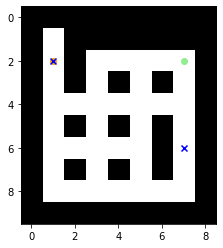

{(2, 1): 0, (3, 1): 0, (4, 1): 2, (4, 2): 0, (4, 3): 2, (3, 3): 0, (2, 3): 1, (2, 4): 0, (2, 5): 0, (2, 6): 0, (2, 7): 3}


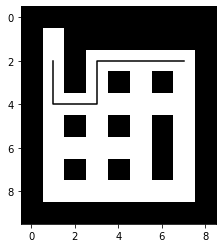

In [16]:
with open('robot/test_mazes/maze.txt') as f:
    maze = f.read().strip()
    start = None
    goal = None
    offset_y = 0
    offset_x = 0
    rows = maze.split('\n')
    for i, row in enumerate(rows):
        s = row.find('S')
        if s != -1:
            offset_y = ((len(rows)+1)+i)%2
            offset_x = s%2
            start = (len(rows)-i,s+1)
            
        g = row.find('G')
        if g != -1:
            goal = (len(rows)-i,g+1)
    
    size_y = len(rows)
    size_x = max([len(row) for row in rows])
            
    env = full((size_y, size_x), 1)
    
    for y in range(size_y-1, -1, -1):
        for x in range(len(rows[y])):
            env[size_y-y-1][x] = (rows[y][x] == ' ')*1
    
    
    import matplotlib.pyplot as plt
    
    env2 = full((size_y+2,size_x+2),1)
    
    for i in range(1,size_y+1):
        for j in range(1,size_x+1):
            env2[i][j] = env[i-1][j-1]
    plt.imshow(env2, cmap='binary')
    plt.scatter(*start[::-1], c='orange')
    plt.scatter(*goal[::-1], c='lightgreen')
    
    straights = []
    for i in range(1+offset_y,len(env2)-1,2):
        for j in range(1+offset_x, len(env2[i])-1,2):
            if (env2[i][j]+env2[i+1][j]+env2[i-1][j] == 0 and env2[i][j-1]+env2[i][j+1] == 2) or (env2[i][j]+env2[i][j+1]+env2[i][j-1] == 0 and env2[i-1][j]+env2[i+1][j] == 2):
                straights.append((i,j))
    print(straights)
    for pt in straights:
        plt.scatter(*pt[::-1], c='blue', marker='x')
    
    print(start, goal)
    
    plt.show()
    plt.imshow(env2, cmap='binary')
    instr_dict = get_instruction_dict(start, goal, env2) 
    path = a_star(start, goal, env2, heuristic=manhattan)
    plt.plot([p[1] for p in path], [p[0] for p in path], 'black')
    print(instr_dict)

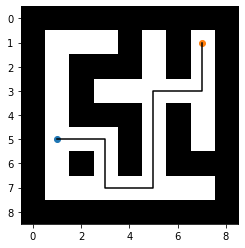

In [11]:
from math import ceil
from random import randint
import matplotlib.pyplot as plt

def generate_maze(n=4, rem=None):
    env = full((2*n+1,)*2, 1)
    for i in range(n):
        for j in range(n):
            env[2*i+1][2*j+1] = 0
            env[2*i+1][min(2*j+2,2*n-1)] = 0
            env[min(2*i+2,2*n-1)][2*j+1] = 0
       
    k = 0
    if not rem:
        rem = n
    while k < rem:
        i = (randint(1,2*n-1))
        j = (randint(1,2*n-1))
        
        if env[i][j] == 0 and i%2+j%2 < 2:
            env[i][j] = 1
            k += 1

    S = (2*randint(1, n)-1, 2*randint(1, n)-1)
    G = (2*randint(1, n)-1, 2*randint(1, n)-1)
    
    return env, S, G

env, S, G = generate_maze(n=4, rem=8)
plt.imshow(env, cmap='binary')
plt.scatter(*S)
plt.scatter(*G)

path = a_star(S[::-1], G[::-1], env)
plt.plot([p[1] for p in path], [p[0] for p in path], c='black')

In [17]:
def solve(env, start, goal, red_pos, blue_pos):
    red_blocks = []
    gen_path = []
    last_pos = start
    case = None

    while True:
        path = a_star(last_pos, goal, env)
        if len(red_blocks) == 2 or (not path and len(red_blocks) != 0):
            min_path_len, min_path_start = 9999, None
            min_next_pos = None
            min_push_pos = None
            print(red_blocks)
            for push_pos, block_pos in red_blocks:
                d = 2*(block_pos[0]-push_pos[0]),2*(block_pos[1]-push_pos[1])
                new_block_pos = block_pos[0]+d[0],block_pos[1]+d[1]
                print(new_block_pos)
                if env[new_block_pos[0]][new_block_pos[1]] == 1:
                    continue
                    
                env[new_block_pos[0]][new_block_pos[1]] = 1
                env[block_pos[0]][block_pos[1]] = 0
                
                path = a_star(block_pos, goal, env)
                
                env[new_block_pos[0]][new_block_pos[1]] = 0
                env[block_pos[0]][block_pos[1]] = 1
                
                if path and min_path_len > len(path):
                    min_path_len = len(path)
                    min_path_start = block_pos
                    min_next_pos = new_block_pos
                    min_push_pos = push_pos
                    
            path = a_star(last_pos, min_push_pos, env)
            
            
            env[min_next_pos[0]][min_next_pos[1]] = 1
            env[min_path_start[0]][min_path_start[1]] = 0
            
            for p in path:
                gen_path.append(p)
            
            last_pos = min_path_start
            red_blocks = []
            red_pos.remove(min_path_start)
            continue#return gen_path
                
            
            
        for p in path:
            gen_path.append(p)
            if p in red_pos:
                red_blocks.append((last_pos,p))
                env[p[0]][p[1]] = 1
                break
            elif p in blue_pos:
                env[p[0]][p[1]] = 1
                break
            if p == goal:
                return gen_path
            last_pos = p

[((4, 2), (4, 3))]
(4, 5)


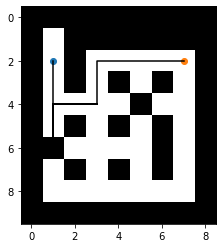

In [18]:
import copy
path = solve(env2, start, goal, [(4,3),(6,5)], [(6,1)])
plt.imshow(env2, cmap='binary')
plt.scatter(*start[::-1])
plt.scatter(*goal[::-1])
plt.plot([p[1] for p in path], [p[0] for p in path], c='black')

In [18]:
def to_ascii(env, start, goal):
    asc = ''
    for y in range(len(env)-2, 0, -1):
        for x in range(1, len(env[y])-1):
            if (y,x) == start:
                asc += 'S'
            elif (y,x) == goal:
                asc += 'G'
            else:
                asc += '* '[env[y][x]]
        asc += '\n'
    return asc


with open('test.txt', 'w') as f:
    f.write(to_ascii(env, S[::-1], G[::-1]))